In [1]:
import numpy as np
import pandas as pd
import json
import pickle
import string

In [3]:
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

## Fine-tuning choose all factiva sentences

In [4]:
factiva_results_folder ='../data/factiva'
gpt3_data_folder = 'gpt3_train'

path = Path(gpt3_data_folder)
path.mkdir(parents=True, exist_ok=True)

In [5]:
# create a temp folder for intermittent files 
path = Path('temp')
path.mkdir(parents=True, exist_ok=True)

### Load original sentences generated from factiva dataset

In [6]:
orig_sentences = pd.read_json('{}/temp/orig_sentences.jsonl'.format(factiva_results_folder),
                              lines = True)
orig_sentences = orig_sentences[['id', 'content']]
orig_sentences = pd.concat([orig_sentences.drop(columns='content'),
                             pd.DataFrame(orig_sentences.content.tolist())], axis = 1)
orig_sentences = orig_sentences.explode(['sentences', 'sentences_idx']).reset_index(drop = True)
orig_sentences.loc[:, 'sentence_id'] = orig_sentences.id + '_' + orig_sentences.sentences_idx.astype(str)
orig_sentences = orig_sentences[['sentence_id', 'sentences']].rename(columns = {'sentences':'true_text'})

In [ ]:
orig_sentences.head(2)

In [7]:
orig_sentences.shape

(461180, 2)

### Load co-referenced data generated from factiva dataset

In [8]:
coref_sentences = json.load(open('{}/temp/coref_sentences.json'.format(factiva_results_folder), 'r'))
coref_sentences = pd.DataFrame({'sentence_id': coref_sentences[0], 'text': coref_sentences[1]})

In [9]:
coref_sentences.shape

(455962, 2)

In [10]:
df = pd.merge(orig_sentences, coref_sentences)

In [ ]:
df.head(2)

In [11]:
df.shape

(455962, 3)

In [12]:
# group by original text and pick top 1 to filter out duplicate texts
# https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-from-a-string-in-python-3-x-using-translate
df.loc[:, 'text_lo'] = df.true_text.str.translate(str.maketrans('', '', string.punctuation))
df.loc[:, 'text_lo'] = df.text_lo.\
    apply(lambda x: ' '.join([i.lower() for i in x.split() if i.isalpha()]))
df = df.groupby(['text_lo']).head(1).\
    reset_index(drop = True).\
    drop(columns=['text_lo'])

In [13]:
# co-referenced text different from original text
df[df.true_text != df.text].shape[0]/df.shape[0]

0.7012488015000732

In [14]:
# co-referenced text same as original text
df[df.true_text == df.text].shape[0]/df.shape[0]

0.2987511984999268

In [15]:
df[df.true_text != df.text].shape[0]

296941

In [16]:
df[df.true_text == df.text].shape[0]

126505

### Create embeddings

In [21]:
def get_embeddings(data, model_name='all-MiniLM-L6-v2', device='cuda', convert=False):
    smodel = SentenceTransformer(model_name, device=device)
    embeddings = smodel.encode(data, batch_size=64, show_progress_bar=True, convert_to_tensor=convert)
    return(embeddings)

In [22]:
# Sentences that have no changes b/w original and coref sentences
# to train GPT-3
df = df[df.true_text == df.text].reset_index(drop = True)
sents = df.true_text.tolist()

# all-MiniLM-L6-v2 all-distilroberta-v1
embeddings = get_embeddings(sents, model_name='all-MiniLM-L6-v2', device='cuda', convert=False)

pickle.dump(embeddings, 
            open('temp/sents_minus_coref_embedding_minilm.pk',
                             'wb'))

Batches:   0%|          | 0/1977 [00:00<?, ?it/s]

### Paraphrase mining for sentence similarity

In [24]:
# :param embeddings: A tensor with the embeddings
# :param query_chunk_size: Search for most similar pairs for #query_chunk_size at the same time. 
# Decrease, to lower memory footprint (increases run-time).
# :param corpus_chunk_size: Compare a sentence simultaneously against 
 #corpus_chunk_size other sentences. Decrease, to lower memory footprint (increases run-time).
# :param max_pairs: Maximal number of text pairs returned.
# :param top_k: For each sentence, we retrieve up to top_k other sentences
# :param score_function: Function for computing scores. By default, cosine similarity.
# :return: Returns a list of triplets with the format [score, id1, id2]


In [120]:
result = util.paraphrase_mining_embeddings(embeddings,
                                  query_chunk_size= 5000,
                                  corpus_chunk_size = 10000,
                                  max_pairs = 500000,
                                  top_k = 1000)
result = pd.DataFrame(result)
result.columns = ['score', 'idx1', 'idx2']
result.to_pickle('temp/sents_minus_coref_embedding_mining_result.pk')

## Evaluate mining result

In [31]:
# create linked statements
# combine similar sentences: id1 ~ id2, id2 ~ id4, id2 ~ id5
# then result: id1: [id2, id4, id5]
def get_dependency_sentences(similar_list):
    forest = {}
    already_seen = {}
    for similar_tuple in similar_list:
        parent_id, id = similar_tuple
        if parent_id in forest.keys():
            forest[parent_id].append(id)
            already_seen[id] = parent_id
        elif parent_id in already_seen.keys():
            forest[already_seen[parent_id]].append(id)
            already_seen[id] = already_seen[parent_id]
        elif id in already_seen.keys():
            forest[already_seen[id]].append(parent_id)
            already_seen[parent_id] = already_seen[id]
        else:
            forest[parent_id] = []
            forest[parent_id].append(id)
            already_seen[id] = parent_id
    return forest


### Combine all linked (similar) sentences

In [26]:
# read results from paraphrase mining
result = pd.read_pickle('temp/sents_minus_coref_embedding_mining_result.pk')

# set a minimal threshold 
# remove 0.99 and 1 as they are very similar sentences with minor differences with added comma, a/an etc.
result = result[result.score < 0.99]
result = result[result.score >= 0.75]

# sort the indexes row wise so that idx1 always has the minimum index
similar = result[['idx1', 'idx2']]
similar.loc[:, 'idx1_sorted'] = similar[['idx1','idx2']].min(axis=1)
similar.loc[:, 'idx2_sorted'] = similar[['idx1','idx2']].max(axis=1)

# sort the indexes column wise so you have similar indexes together
similar = similar.sort_values(['idx1_sorted', 'idx2_sorted']).reset_index()
# get a list of tuples of similar indexes
similar = similar[['idx1_sorted','idx2_sorted']].apply(tuple, axis=1).tolist()

# merge the indexes with their respective sentence ids
result.loc[:, 'id1'] = df.loc[result.idx1, 'sentence_id'].tolist()
result.loc[:, 'id2'] = df.loc[result.idx2, 'sentence_id'].tolist()
result.loc[:, 'combined_id'] = result['id1'] +'-'+ result['id2']
result.loc[:, 'combined_id'] = result['combined_id'].apply(lambda x: '-'.join(np.sort(x.split('-'))))

In [29]:
similar[0:2]

[(15, 81075), (20, 82507)]

In [30]:
result.head(2)

,score,idx1,idx2,id1,id2,combined_id
372,0.989923,10825,113886,ad84b6c2-7ff0-400c-b1b4-b2946ae9564f_29,86650d6c-02bb-4d68-919b-996125f14493_29,02bb-400c-4d68-7ff0-86650d6c-919b-996125f14493...
373,0.989896,35617,53336,e64a346b-a8a5-4c25-8f7a-7fec8ba5fd77_45,87acec23-519d-4893-a040-fb66ea6b098c_45,4893-4c25-519d-7fec8ba5fd77_45-87acec23-8f7a-a...


In [32]:
# combine similar sentences: id1 ~ id2, id2 ~ id4
# then result: id1: [id2, id4]
forest = get_dependency_sentences(similar)

In [40]:
# print combined ids
for i, (k, v) in enumerate(forest.items()):
    print('{}: {}'.format(k, v))
    
    if i == 5:
        break

15: [81075]
20: [82507]
40: [37570]
52: [53]
64: [14159]
88: [118017]


In [41]:
# merge sentence ids
forest_sents = []
for key, val in forest.items():
    val = list(set(val))
    forest_sents.append({'main_sent':sents[key],
                         'main_id':df.loc[key].sentence_id, 
                         'matching_sent': [sents[v] for v in val],
                         'matching_id': [df.loc[v].sentence_id for v in val],})

In [42]:
forest_sents=pd.DataFrame(forest_sents)
forest_sents = forest_sents.explode(['matching_sent', 'matching_id']).reset_index(drop = True)
# forest_sents['seq'] = list(range(0, forest_sents.shape[0]))

In [43]:
forest_sents.head(2)

,main_sent,main_id,matching_sent,matching_id
0,Culture matters.,8709d620-8152-47fe-86cd-df3035156d71_35,Culture counts.,de246161-7166-4d06-96e5-f36c93014308_46
1,Highest standards,42c90996-c3c9-44dd-9c45-aa6ed9c4839b_7,Different standards,7e52273b-e3d2-451f-bfb2-e453fa8d6ee3_20


### Merging cluster labels and similarity scores to similar sentences

In [44]:
forest_sents.shape

(15702, 4)

In [45]:
similar_df = forest_sents.copy()
similar_df.loc[:, 'combined_id'] = similar_df['main_id'] +'-'+ similar_df['matching_id']
similar_df.loc[:, 'combined_id'] = similar_df['combined_id'].apply(lambda x: '-'.join(np.sort(x.split('-'))))

In [46]:
similar_df = pd.merge(similar_df, result[['score', 'combined_id']], on='combined_id')

In [47]:
similar_df = similar_df.drop(columns = 'combined_id').reset_index(drop = True)

In [48]:
similar_df.to_pickle('temp/similar_sentences_minus_coref_df.pkl')

### Evaluate similar sentences

In [49]:
similar_df = pd.read_pickle('temp/similar_sentences_minus_coref_df.pkl')

In [50]:
similar_df = similar_df.sort_values('score', ascending = False)

<AxesSubplot:>

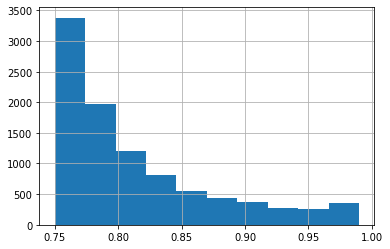

In [51]:
similar_df.score.hist()

### Create train data

In [52]:
train = similar_df.copy()
train['val1'] = train.main_sent.str.split(' ').apply(set)
train['val2'] = train.matching_sent.str.split(' ').apply(set)
# get unique words between sentences
train['diff1'] = train.val1 - train.val2
train['diff2'] = train.val2 - train.val1
train['l1'] = train.val1.apply(len)
# filter for sentences greater than length 5 
train = train[train.l1 > 5]
train = train.drop(columns=['val1', 'val2', 'l1'])
train['len1'] = train.diff1.apply(len)
train['len2'] = train.diff2.apply(len)
train['sample_len'] = train[['len1', 'len2']].max(axis = 1)

array([[<AxesSubplot:title={'center':'score'}>,
        <AxesSubplot:title={'center':'len1'}>],
       [<AxesSubplot:title={'center':'len2'}>,
        <AxesSubplot:title={'center':'sample_len'}>]], dtype=object)

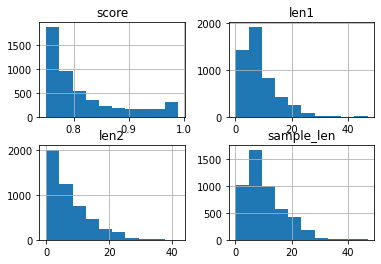

In [53]:
train.hist()

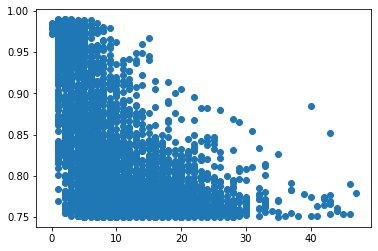

In [54]:
# similarity score v/s length of sentences
plt.scatter(train.sample_len, train.score)

In [55]:
# get the different words between similar sentences
train[train.len1<=10][['diff1', 'diff2', 'score', 'len1', 'len2']].head(5)

,diff1,diff2,score,len1,len2
2841,"{is, not}",{isn't},0.989923,2,1
6413,"{This, month,}","{this, month, Earlier}",0.989896,2,3
653,"{prolific, women}","{women,}",0.989889,2,1
606,{way},{},0.989788,1,0
7761,{governing},{on},0.989516,1,1


In [57]:
## not printing sentences
train.drop(columns=['main_sent', 'matching_sent']).head(2)

,main_id,matching_id,score,diff1,diff2,len1,len2,sample_len
2841,ad84b6c2-7ff0-400c-b1b4-b2946ae9564f_29,86650d6c-02bb-4d68-919b-996125f14493_29,0.989923,"{is, not}",{isn't},2,1,2
6413,e64a346b-a8a5-4c25-8f7a-7fec8ba5fd77_45,87acec23-519d-4893-a040-fb66ea6b098c_45,0.989896,"{This, month,}","{this, month, Earlier}",2,3,3


In [58]:
idx=10
train.iloc[idx].main_sent

'Or can art objects that have legally moved from one part of the world to another be viewed as cultural ambassadors that promote understanding between people?'

In [59]:
train.iloc[idx].matching_sent

'Or can it be argued that art objects that have legally moved from one part of the world to another can be viewed as cultural ambassadors that promote understanding between people?'

### Create GPT-3 train dataset

In [60]:
train_ids = train[['main_sent','main_id', 'matching_sent','matching_id']].\
        drop_duplicates().\
        reset_index(drop = True)

In [62]:
train_ids.head(0) # not printing sentences

,main_sent,main_id,matching_sent,matching_id


In [63]:
train_ids.shape

(4961, 4)

In [64]:
train_ids.to_json('temp/train_data_samples_ids.jsonl',
                     lines = True, orient='records')

In [65]:
# shuffle train data
train_sample = train[['main_sent', 'matching_sent']].\
        drop_duplicates().\
        sample(frac=1, random_state=10).\
        reset_index(drop = True).\
        rename(columns = {'main_sent': 'prompt', 'matching_sent':'completion'})
train_sample.to_json('{}/train_data_samples.jsonl'.format(gpt3_data_folder),
                     lines = True, orient='records')

In [67]:
train_sample.shape

(4961, 2)